IMPORTING THE LIBRARIES

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from bertopic import BERTopic
# import gensim
# from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [199]:
file = [
    "Gachibowli_AB.csv",
    "Jubilee_hills_AB.csv",
    "Marathahalli_AB.csv",
    "BTM_Layout_AB.csv",
    "Mumbai_AB.csv",
    "Whitefield_AB.csv",
    "Banjara_hills_AB.csv"
]

In [200]:
#Read all CSV files and concatenate them into a single DataFrame
dfs = []
for file in file:
    df = pd.read_csv(file)
    dfs.append(df)

#Combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [201]:
combined_df.shape

(8123, 7)

In [202]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


In [203]:
#Remove rows where the "Review" column is empty
combined_df.dropna(subset=['Review'], inplace=True)

In [204]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


SAVING THE DATAFRAME TO CSV

In [205]:
combined_df.to_csv("AB_Complaints.csv")

HANDLING MISSING VALUES

In [206]:
combined_df.isnull().sum()

Name                 0
Review_Date          0
Review               0
Owner_Response    2251
Response_Date     2593
Response          2251
Review_Date.1     3863
dtype: int64

In [207]:
combined_df.drop(columns=['Owner_Response','Review_Date.1'],axis=1,inplace=True)

In [208]:
# Fill Response_Date where it is NaT (missing) and Response is not NaT (exists)
combined_df.loc[combined_df['Response_Date'].isna() & combined_df['Response'].notna(), 'Response_Date'] = combined_df['Review_Date']

In [209]:
combined_df.isnull().sum()

Name                0
Review_Date         0
Review              0
Response_Date    2251
Response         2251
dtype: int64

DATA PREPROCESSING

In [210]:
import re
import nltk
from nltk.corpus import stopwords

# Function to preprocess reviews
def preprocess_review(review):
    review = review.lower()  # Convert to lowercase
    review = re.sub(r'[^a-zA-Z\s]', '', review)  # Remove punctuation and numbers
    review = re.sub(r'\s+', ' ', review).strip()  # Remove extra whitespace

    # Tokenization
    tokens = nltk.word_tokenize(review)  # Tokenize after cleaning
    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    
    # Join filtered tokens back into a string
    return " ".join(filtered_tokens)

# Assuming you have your DataFrame combined_df
combined_df['Cleaned_Review'] = combined_df['Review'].apply(preprocess_review)

# Display the updated DataFrame
combined_df[['Review', 'Cleaned_Review']].head()


,Review,Cleaned_Review
0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...
1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience
2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...
3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...
4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...


In [211]:
def preprocess_name(name):
    name = name.lower()  # Convert to lowercase
    name = re.sub(r'[^a-zA-Z\s]', '', name)  # Remove non-alphabetic characters
    return name.strip()  # Remove leading/trailing whitespace

combined_df['Cleaned_Name'] = combined_df['Name'].apply(preprocess_name)
combined_df[['Name', 'Cleaned_Name']].head()

,Name,Cleaned_Name
0,Pramod Kumar,pramod kumar
1,abhinav deep,abhinav deep
2,Vijay Nammi,vijay nammi
3,surya ajay,surya ajay
4,Sai Hithesh,sai hithesh


In [212]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh


TOPIC MODELING USING BERTopic

In [117]:
# Set a random seed for reproducibility
np.random.seed(42)



# Check if the 'Review' column exists
if 'Cleaned_Review' not in combined_df.columns:
    raise ValueError("The DataFrame does not contain a 'Cleaned_Review' column.")

# Load a pre-trained Sentence Transformer model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a UMAP instance with desired parameters
umap_model = UMAP(n_neighbors=40, min_dist=0.0, metric='cosine', random_state=42)

# Create an HDBSCAN instance with desired parameters
hdbscan_model = HDBSCAN(min_cluster_size=10)

# Create a BERTopic model with the UMAP and HDBSCAN instances
topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)

# Fit the model on the processed reviews
topics, probabilities = topic_model.fit_transform(combined_df['Cleaned_Review'].tolist())

# Get topic information
topic_info = topic_model.get_topic_info()

# Display the number of topics found (including "Topic 0")
num_topics = topic_info.shape[0]
print(f'Number of topics: {num_topics}')

# Display topics with their keywords in a more readable format
print("\nTopics and their keywords:")
for i in range(num_topics):
    try:
        # Get topic keywords
        topic_keywords = topic_model.get_topic(i)
        # Check if topic_keywords is not None or empty
        if topic_keywords:
            # Format the output
            formatted_keywords = ", ".join([word for word, _ in topic_keywords])
            # Get the number of documents assigned to this topic
            num_documents = topic_info[topic_info['Topic'] == i]['Count'].values[0]
            print(f"Topic {i}: {formatted_keywords} (Documents: {num_documents})")
        else:
            print(f"Topic {i} has no keywords.")
    except Exception as e:
        print(f"Error retrieving keywords for Topic {i}: {e}")


Number of topics: 56

Topics and their keywords:
Topic 0: nation, barbecue, barbeque, bbq, absolute, grill, better, food, items, taste (Documents: 345)
Topic 1: abs, experience, food, disappointed, quality, worst, visited, time, first, taste (Documents: 182)
Topic 2: vegetarian, vegetarians, options, non, less, good, option, veg, place, food (Documents: 144)
Topic 3: course, main, starters, desserts, good, starter, deserts, average, dessert, biryani (Documents: 144)
Topic 4: waiters, time, service, wait, table, order, even, times, starters, minutes (Documents: 128)
Topic 5: booking, table, booked, pm, reservation, wait, mins, reserved, seats, us (Documents: 109)
Topic 6: ambience, food, good, service, ok, music, okay, great, nice, taste (Documents: 102)
Topic 7: prawns, buffet, fish, dishes, veg, chicken, menu, taste, variety, items (Documents: 66)
Topic 8: taste, mark, upto, food, varieties, tasty, improved, hows, quality, worthy (Documents: 64)
Topic 9: staff, food, good, friendly, c

In [213]:
category_labels = ['Service Issue', "Technical Issue", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
topic_labels = {
    -1:["Others"],
    0: ["Food Quality"],                  # BBQ references
    1: ["Food Quality"],                  # Comparison of BBQ
    2: ["Food Quality"],             # Vegetarian options
    3: ["Food Quality"],               # General experience
    4: ["Service Issue","Technical Issue"], # Ambience and service
    5: ["Technical Issue"],                # Course quality
    6: ["Atmosphere","Food Quality","Service Issue"],                                # General service
    7: ["Food Quality"],                  # Buffet experience
    8: ["Food Quality"],                              # Reservation issues
    9: ["Atmosphere","Food Quality","Service Issue"],               # General atmosphere
    10: ["Value for Money","Food Quality"],              # Service and food quality
    11: ["Atmosphere"],                               # Food taste
    12: ["Service Issue","Food Quality"],                                     # Branch-specific experience
    13: ["Food Quality"],                               # Meat taste
    14: ["Food Quality"],                # Staff friendliness
    15: ["Atmosphere"],                                     # City comparison
    16: ["Service Issue"],            # Vegetarian options
    17: ["Service Issue","Food Quality"],                            # Price quality
    18: ["Atmosphere"],                               # Taste quality
    19: ["Food Quality"],                               # Slow service
    20: ["Atmosphere"],                 # Hygiene issues
    21: ["Food Quality"],                               # Taste complaints
    22: ["Food Quality"],                               # Management issues
    23: ["Food Quality"],                             # Starter options
    24: ["Value for Money","Service Issue"],              # Negative experiences
    25: ["Others"],                               # Waiter issues
    26: ["Food Quality"],            # Cooking issues
    27: ["Food Quality"],              # Buffet quality
    28: ["Atmosphere"],                               # Waiter service
    29: ["Technical Issue"],                               # Worst response
    30: ["Hygiene"],                               # Specific dish complaints
    31: ["Hygiene"],                                     # Entertainment issues
    32: ["Service Issue", "Atmosphere"],              # Staff issues
    33: ["Service Issue", "Food Quality"],                               # Market experience
    34: ["Others"],                                    # Stale food
    35: ["Atmosphere"],                                    # Cleanliness issues
    36: ["Food Quality"],                               # Serving issues
    37: ["Others"],                             # Parking issues
    38: ["Atmosphere","Hygiene"],            # Buffet options
    39: ["Atmosphere"],                                     # General complaints
    40: ["Atmosphere","Value for Money"],                               # Dessert issues
    41: ["Service Issue"],                            # General worth
    42: ["Service Issue","Food Quality"],                               # Attitude issues
    43: ["Atmosphere"],                                     # Review issues
    44: ["Others"],                               # Specific dish complaints
    45: ["Food Quality"],                             # Menu issues
    46: ["Food Quality"],                               # Crowding
    47: ["Atmosphere"],                                  # Buffet quality
    48: ["Food Quality"],                                     # General drinking issues
    49: ["Hygiene"],                               # Waiter issues
    50: ["Food Quality","Hygiene"],                             # Crowding issues
    51: ["Food Quality","Hygiene"],                             # Booking issues
    52: ["Technical Issue"],
    53: ["Food Quality"],
    54: ["Value for Money"],
    55: ["Others"]                             # No keywords
}

topic_info['Label'] = topic_info['Topic'].map(topic_labels)
topic_info[['Topic', 'Count', 'Label']]


,Topic,Count,Label
0,-1,1655,[Others]
1,0,345,[Food Quality]
2,1,182,[Food Quality]
3,2,144,[Food Quality]
4,3,144,[Food Quality]
5,4,128,"[Service Issue, Technical Issue]"
6,5,109,[Technical Issue]
7,6,102,"[Atmosphere, Food Quality, Service Issue]"
8,7,66,[Food Quality]
9,8,64,[Food Quality]


ANALYZING AND VISUALIZING CATEGORY DISTRIBUTION

Label
[Food Quality]                               19
[Atmosphere]                                  9
[Others]                                      5
[Service Issue, Food Quality]                 4
[Technical Issue]                             3
[Hygiene]                                     3
[Atmosphere, Food Quality, Service Issue]     2
[Service Issue]                               2
[Food Quality, Hygiene]                       2
[Service Issue, Technical Issue]              1
[Value for Money, Food Quality]               1
[Value for Money, Service Issue]              1
[Service Issue, Atmosphere]                   1
[Atmosphere, Hygiene]                         1
[Atmosphere, Value for Money]                 1
[Value for Money]                             1
Name: count, dtype: int64


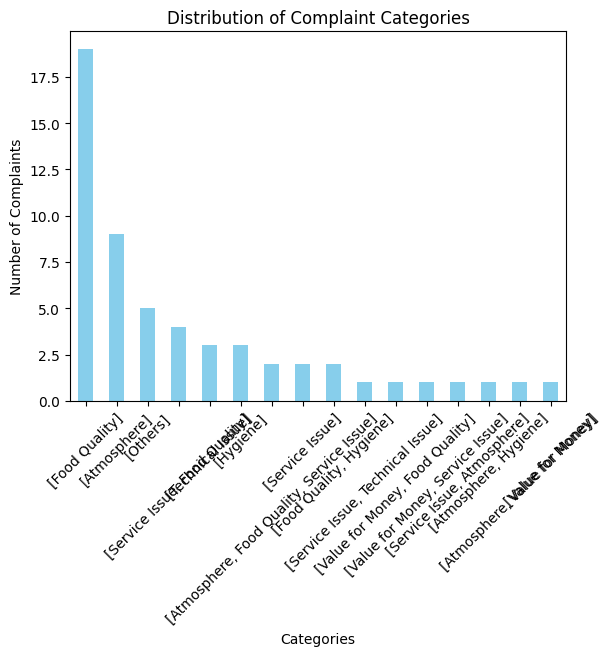

In [214]:
# Count occurrences of each label
category_counts = topic_info['Label'].value_counts()
print(category_counts)


category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()

MAPPING TOPICS TO CATEGORIES

In [215]:
combined_df['Topics'] = topics

combined_df['Category'] = combined_df['Topics'].map(topic_labels)

CONVERTING REVIEW DATE TO DAYS

In [216]:
def convert_to_days(review_dates):
    # Check if the input is null or empty
    if pd.isnull(review_dates) or review_dates.strip() == '':
        return -1  # Store -1 for null values
    
    # Create a dictionary for conversion
    time_in_days = {
        'year': 365,
        'month': 30,
        'week': 7,
        'day': 1
    }
    
    list1 = review_dates.split()[:2]  # Only take the first two words
    days = 0
    
    number = 1 if list1[0] == 'a' else int(list1[0])
    unit = list1[1].rstrip('s')  # Remove the plural 's'
    
    days += number * time_in_days[unit]
    
    return days


In [217]:
combined_df['Review_Days'] = combined_df['Review_Date'].map(convert_to_days)

In [218]:
combined_df.isnull().sum()

Name                 0
Review_Date          0
Review               0
Response_Date     2251
Response          2251
Cleaned_Review       0
Cleaned_Name         0
Topics               0
Category             0
Review_Days          0
dtype: int64

IDENTIFYING UNIQUE AND REPEAT CUSTOMERS

In [219]:
#Finding Unique Customers
dictionary = combined_df['Cleaned_Name'].value_counts()
dictionary = dictionary.to_dict()

In [220]:
combined_df['Unique_Customer'] = combined_df['Cleaned_Name'].apply(lambda x: 'First_Time' if dictionary[x] == 1 else 'Repeat')

In [171]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Topics                0
Category              0
Review_Days           0
Unique_Customer       0
dtype: int64

SEVERITY CLASSIFICATION USING SENTIMENT ANALYSIS

In [127]:
from transformers import pipeline

# Load a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Analyze sentiment
sentiments = sentiment_pipeline(combined_df['Cleaned_Review'].tolist())
list (sentiments)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9993200302124023},
 {'label': 'POSITIVE', 'score': 0.9989683628082275},
 {'label': 'NEGATIVE', 'score': 0.999792754650116},
 {'label': 'NEGATIVE', 'score': 0.9995315074920654},
 {'label': 'NEGATIVE', 'score': 0.9987488985061646},
 {'label': 'NEGATIVE', 'score': 0.9986369013786316},
 {'label': 'NEGATIVE', 'score': 0.9904683232307434},
 {'label': 'NEGATIVE', 'score': 0.9980587363243103},
 {'label': 'NEGATIVE', 'score': 0.9968034029006958},
 {'label': 'NEGATIVE', 'score': 0.9990240335464478},
 {'label': 'NEGATIVE', 'score': 0.6061038970947266},
 {'label': 'NEGATIVE', 'score': 0.9996324777603149},
 {'label': 'NEGATIVE', 'score': 0.9994240999221802},
 {'label': 'NEGATIVE', 'score': 0.9955106973648071},
 {'label': 'NEGATIVE', 'score': 0.9995400905609131},
 {'label': 'NEGATIVE', 'score': 0.9991546869277954},
 {'label': 'NEGATIVE', 'score': 0.9974332451820374},
 {'label': 'NEGATIVE', 'score': 0.9997349381446838},
 {'label': 'NEGATIVE', 'score': 0.9957938194274

SENTIMENT ANALYSIS USING TEXTBLOB

In [221]:
from textblob import TextBlob

In [222]:
# Function to calculate sentiment using TextBlob
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity  # Return polarity score

# Apply the function to the 'Review' column
combined_df['Sentiment_Score'] = combined_df['Cleaned_Review'].apply(get_sentiment)

In [223]:
def get_severity(sentiment_score):
	if sentiment_score > 0.1:
		return "Low"
	elif sentiment_score >= -0.1:
		return "Medium"
	else:
		return "High"



# Apply the function to the sentiment scores
combined_df['Severity'] = combined_df['Cleaned_Review'].apply(lambda review: get_severity(TextBlob(review).sentiment.polarity))

# Display the updated DataFrame
combined_df['Severity'].value_counts()

Severity
Low       2120
High      1079
Medium    1006
Name: count, dtype: int64

In [224]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Topics                0
Category              0
Review_Days           0
Unique_Customer       0
Sentiment_Score       0
Severity              0
dtype: int64

In [176]:
list1 = list(combined_df['Cleaned_Review'])

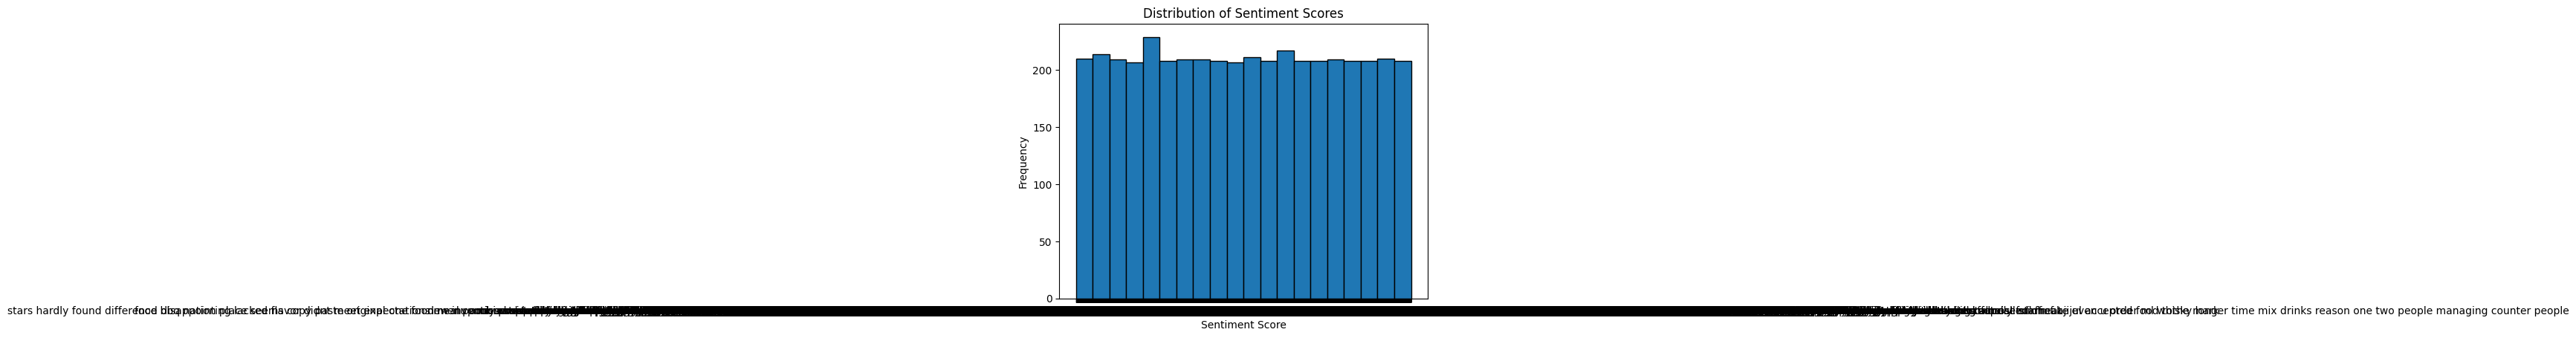

In [84]:
# Assuming 'sentiment_scores' is a list of sentiment scores
plt.hist(list1, bins=20, edgecolor='black')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

IDENTIFYING FREQUENCY OF COMPLAINT TYPE USING TF-IDF AND COSINE SIMILARITY

In [225]:
# creating TfidfVectorizer

vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(combined_df["Cleaned_Review"])

In [226]:
threshold = 0.7

In [227]:
cosine_sim = cosine_similarity(x, x)

In [228]:
combined_df['Is_Repeated'] = False

# Step 5: Loop through the similarity matrix and mark similar reviews
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i][j] > threshold:
            combined_df.loc[j, 'Is_Repeated'] = True  # Mark the repeated review

In [229]:
combined_df['Is_Repeated'].value_counts()

Is_Repeated
False    4140
True      113
Name: count, dtype: int64

In [230]:
combined_df.isnull().sum()

Name                 48
Review_Date          48
Review               48
Response_Date      2299
Response           2299
Cleaned_Review       48
Cleaned_Name         48
Topics               48
Category             48
Review_Days          48
Unique_Customer      48
Sentiment_Score      48
Severity             48
Is_Repeated           0
dtype: int64

In [231]:
combined_df['Frequency_Of_Complaint_Type'] = combined_df['Is_Repeated'].apply(lambda x: 'Repeated' if x == True else 'Unique')

In [232]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
dtype: int64

COMPLAINT URGENCY

In [233]:
combined_df['Urgency'] = combined_df['Sentiment_Score'].apply(lambda x: 'Urgent' if x < -0.1 else 'Non-Urgent') 

In [234]:
combined_df['Urgency'].value_counts()

Urgency
Non-Urgent    3174
Urgent        1079
Name: count, dtype: int64

In [235]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
dtype: int64

ACKNOWLEDGEMENT TIME (RESPONSE TIME)

In [236]:
combined_df['Response_Days'] = combined_df['Response_Date'].map(convert_to_days)

In [237]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
dtype: int64

CALCULATING CUSTOMER SATISFACTION BASED ON RESPONSE AND REVIEW DAYS

In [238]:
# Customer Satisfaction Function based on Response_Days and Review_Days
def calculate_satisfaction(response_days, review_days):
    if response_days == -1:  # No response case
        return 'No Response'
    
    days_difference = response_days - review_days  # Calculate difference internally
    
    if days_difference <= 0:
        return 'High Satisfaction'  # Response was immediate or before the review
    elif 1 <= days_difference <= 3:
        return 'Medium Satisfaction'  # Response within a few days
    else:
        return 'Low Satisfaction'  # Delayed response

# Apply the customer satisfaction calculation
combined_df['Customer_Satisfaction'] = combined_df.apply(
    lambda row: calculate_satisfaction(row['Response_Days'], row['Review_Days']),
    axis=1
)

# Display the DataFrame with customer satisfaction
combined_df[['Review_Date', 'Response_Days', 'Review_Days', 'Response_Days', 'Customer_Satisfaction']]

,Review_Date,Response_Days,Review_Days,Response_Days,Customer_Satisfaction
0,6 months ago,-1,180.0,-1,No Response
1,a year ago,365,365.0,365,High Satisfaction
2,a month ago,-1,30.0,-1,No Response
3,a year ago,365,365.0,365,High Satisfaction
4,6 months ago,-1,180.0,-1,No Response
...,...,...,...,...,...
3833,NaN,-1,NaN,-1,No Response
3850,NaN,-1,NaN,-1,No Response
3283,NaN,-1,NaN,-1,No Response
3856,NaN,-1,NaN,-1,No Response


In [239]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Topics,Category,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,30.0,[Hygiene],180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep,6.0,"[Atmosphere, Food Quality, Service Issue]",365.0,First_Time,0.000000,Medium,False,Unique,Non-Urgent,365,High Satisfaction
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,14.0,[Food Quality],30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay,-1.0,[Others],365.0,First_Time,-0.772727,High,False,Unique,Urgent,365,High Satisfaction
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,2.0,[Food Quality],180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response


In [240]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64

In [241]:
# Display rows with any null values in the DataFrame
null_rows = combined_df[combined_df.isnull().any(axis=1)]

# Show the DataFrame with null rows
null_rows


,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Topics,Category,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,30.0,[Hygiene],180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,14.0,[Food Quality],30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,2.0,[Food Quality],180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response
5,armaan akhter,a week ago,waste management they gave us time 3.30 PM @Ga...,NaN,NaN,waste management gave us time pm gachibowli br...,armaan akhter,41.0,[Service Issue],7.0,First_Time,-0.375000,High,False,Unique,Urgent,-1,No Response
8,Keshav Akkineni,3 months ago,"The food was not good at all. The plates, spoo...",NaN,NaN,food good plates spoons bowls cleaned properly...,keshav akkineni,-1.0,[Others],90.0,First_Time,-0.083333,Medium,False,Unique,Non-Urgent,-1,No Response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response


DELETING NULL ROWS

In [244]:
# Set the threshold for non-null values
# For example, keep rows with at least 5 non-null values
threshold = 6

# Drop rows with less than the specified threshold of non-null values
combined_df = combined_df.dropna(thresh=threshold)

# Check the number of null values after deletion
print(combined_df.isnull().sum())


Name                              0
Review_Date                       0
Review                            0
Response_Date                  2251
Response                       2251
Cleaned_Review                    0
Cleaned_Name                      0
Topics                            0
Category                          0
Review_Days                       0
Unique_Customer                   0
Sentiment_Score                   0
Severity                          0
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64


In [245]:
combined_df.shape

(4205, 18)

In [247]:

new_df = combined_df[['Cleaned_Review', 'Cleaned_Name', 'Topics', 'Category', 
                      'Severity', 'Is_Repeated', 'Frequency_Of_Complaint_Type', 
                      'Urgency', 'Customer_Satisfaction', 'Review_Days', 
                      'Response_Days']].copy()

# Optionally, reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
new_df.head()


,Cleaned_Review,Cleaned_Name,Topics,Category,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Customer_Satisfaction,Review_Days,Response_Days
0,stop eating place visited bangalores nd punes ...,pramod kumar,30.0,[Hygiene],High,False,Unique,Urgent,No Response,180.0,-1
1,food service ambience,abhinav deep,6.0,"[Atmosphere, Food Quality, Service Issue]",Medium,False,Unique,Non-Urgent,High Satisfaction,365.0,365
2,idiotic varieties price charged varieties boil...,vijay nammi,14.0,[Food Quality],High,False,Unique,Urgent,No Response,30.0,-1
3,posting live one worst places dont visit pathe...,surya ajay,-1.0,[Others],High,False,Unique,Urgent,High Satisfaction,365.0,365
4,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,2.0,[Food Quality],Low,False,Unique,Non-Urgent,No Response,180.0,-1


In [248]:
category_dummies = combined_df['Category'].str.get_dummies(sep=', ')
category_dummies.head()

,'Atmosphere'],'Food Quality','Food Quality'],'Hygiene'],'Service Issue'],'Technical Issue'],'Value for Money'],['Atmosphere',['Atmosphere'],['Food Quality',['Food Quality'],['Hygiene'],['Others'],['Service Issue',['Service Issue'],['Technical Issue'],['Value for Money',['Value for Money']
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [250]:
def add_category_features(df, categories):
    """
    Adds binary columns for each specified category in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The original DataFrame with a 'Category' column containing lists of categories.
    - categories (list of str): List of categories to be added as new columns.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with new binary category columns.
    """
    # Loop through each category and create a new column in the DataFrame
    for category in categories:
        # Check if each category is present in the list of categories for each review
        df[category] = df['Category'].apply(lambda x: 1 if category in x else 0)
    
    return df



# List of categories to be checked and added as columns
categories_to_add = ['Service Issue', "Technical Issue", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
# category_labels = ['Service Issue', "Technical Issue", "Food Quality", "Atmosphere", "Value for Money", "Others", "Hygiene"]
# Apply the function to add the new features
new_df = add_category_features(new_df, categories_to_add)

# Display the updated DataFrame
new_df


,Cleaned_Review,Cleaned_Name,Topics,Category,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Customer_Satisfaction,Review_Days,Response_Days,Hygiene,Atmosphere,Food Quality,Service Issue,Others,Technical Issue,Value for Money
0,stop eating place visited bangalores nd punes ...,pramod kumar,30.0,[Hygiene],High,False,Unique,Urgent,No Response,180.0,-1,1,0,0,0,0,0,0
1,food service ambience,abhinav deep,6.0,"[Atmosphere, Food Quality, Service Issue]",Medium,False,Unique,Non-Urgent,High Satisfaction,365.0,365,0,1,1,1,0,0,0
2,idiotic varieties price charged varieties boil...,vijay nammi,14.0,[Food Quality],High,False,Unique,Urgent,No Response,30.0,-1,0,0,1,0,0,0,0
3,posting live one worst places dont visit pathe...,surya ajay,-1.0,[Others],High,False,Unique,Urgent,High Satisfaction,365.0,365,0,0,0,0,1,0,0
4,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,2.0,[Food Quality],Low,False,Unique,Non-Urgent,No Response,180.0,-1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,place food lovers enjoy food apart dishes rest...,hemanth kumar pallapu,9.0,"[Atmosphere, Food Quality, Service Issue]",Low,False,Unique,Non-Urgent,No Response,1825.0,-1,0,1,1,1,0,0,0
4201,good place visit friends family customised foo...,abhinay maredugonda,-1.0,[Others],Low,False,Unique,Non-Urgent,No Response,1460.0,-1,0,0,0,0,1,0,0
4202,food good service also good compare service co...,devesh gupta,12.0,"[Service Issue, Food Quality]",Low,False,Unique,Non-Urgent,No Response,2555.0,-1,0,0,1,1,0,0,0
4203,nice place hangout small team upto members goo...,raja roy,28.0,[Atmosphere],Low,False,Unique,Non-Urgent,No Response,365.0,-1,0,1,0,0,0,0,0
